In [1]:
import numpy as np
import sympy as smp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
from IPython.display import HTML

In [2]:
# Constants
t, g = smp.symbols('t g')
m1, m2 = smp.symbols('m1 m2')
L1, L2 = smp.symbols('L1 L2')

# Angular functions of time
the1, the2 = smp.symbols(r'\theta_1, \theta_2', cls=smp.Function)
the1 = the1(t)
the2 = the2(t)


def get_angular_derivatives(the1, the2):

    the1_d = smp.diff(the1, t)
    the2_d = smp.diff(the2, t)
    the1_dd = smp.diff(the1_d, t)
    the2_dd = smp.diff(the2_d, t)

    return the1_d, the2_d, the1_dd, the2_dd

def get_linear_positions(the1, the2):

    x1 = L1*smp.sin(the1)
    y1 = -L1*smp.cos(the1)
    x2 = L1*smp.sin(the1) + L2*smp.sin(the2)
    y2 = -L1*smp.cos(the1) - L2*smp.cos(the2)

    return x1, y1, x2, y2

def get_linear_velocities(x1, y1, x2, y2):

    vx1 = smp.diff(x1, t)
    vy1 = smp.diff(y1, t)
    vx2 = smp.diff(x2, t)
    vy2 = smp.diff(y2, t)

    return vx1, vy1, vx2, vy2

def get_Lagrangian(y1, y2, vx1, vy1, vx2, vy2):

    T = (1/2 * m1 * (vx1**2 + vy1**2)) + (1/2 * m2 * (vx2**2 + vy2**2))
    V = m1*g*y1 + m2*g*y2
    L = T - V

    return L

def solve_Lagrange_equations(L, the1_d, the2_d, the1_dd, the2_dd, t):

    LE1 = smp.diff(L, the1) - smp.diff(smp.diff(L, the1_d), t).simplify()
    LE2 = smp.diff(L, the2) - smp.diff(smp.diff(L, the2_d), t).simplify()
    sols = smp.solve([LE1, LE2], (the1_dd, the2_dd), simplify=False, rational=False)

    return sols

def Lambdify(the1_d, the2_d, the1_dd, the2_dd, sols):

    dz1dt_f = smp.lambdify((t,g,m1,m2,L1,L2,the1,the2,the1_d,the2_d), sols[the1_dd])
    dz2dt_f = smp.lambdify((t,g,m1,m2,L1,L2,the1,the2,the1_d,the2_d), sols[the2_dd])
    dthe1dt_f = smp.lambdify(the1_d, the1_d)
    dthe2dt_f = smp.lambdify(the2_d, the2_d)

    return dz1dt_f, dz2dt_f, dthe1dt_f, dthe2dt_f

def dSdt(S, t, g, m1, m2, L1, L2):
    the1, z1, the2, z2 = S
    return [
        dthe1dt_f(z1),
        dz1dt_f(t, g, m1, m2, L1, L2, the1, the2, z1, z2),
        dthe2dt_f(z2),
        dz2dt_f(t, g, m1, m2, L1, L2, the1, the2, z1, z2),
    ]

def get_x1y1x2y2_hist(t, the1, the2, L1, L2):
    return (L1*np.sin(the1),
            -L1*np.cos(the1),
            L1*np.sin(the1) + L2*np.sin(the2),
            -L1*np.cos(the1) - L2*np.cos(the2))

def animate(i):
    ln1.set_data([0, x1_hist[i], x2_hist[i]], [0, y1_hist[i], y2_hist[i]])
    markers.set_data([0, x1_hist[i], x2_hist[i]], [0, y1_hist[i], y2_hist[i]])


the1_d, the2_d, the1_dd, the2_dd = get_angular_derivatives(the1, the2)
x1, y1, x2, y2 = get_linear_positions(the1, the2)
vx1, vy1, vx2, vy2 = get_linear_velocities(x1, y1, x2, y2)
L = get_Lagrangian(y1, y2, vx1, vy1, vx2, vy2)
sols = solve_Lagrange_equations(L, the1_d, the2_d, the1_dd, the2_dd, t)
dz1dt_f, dz2dt_f, dthe1dt_f, dthe2dt_f = Lambdify(the1_d, the2_d, the1_dd, the2_dd, sols)

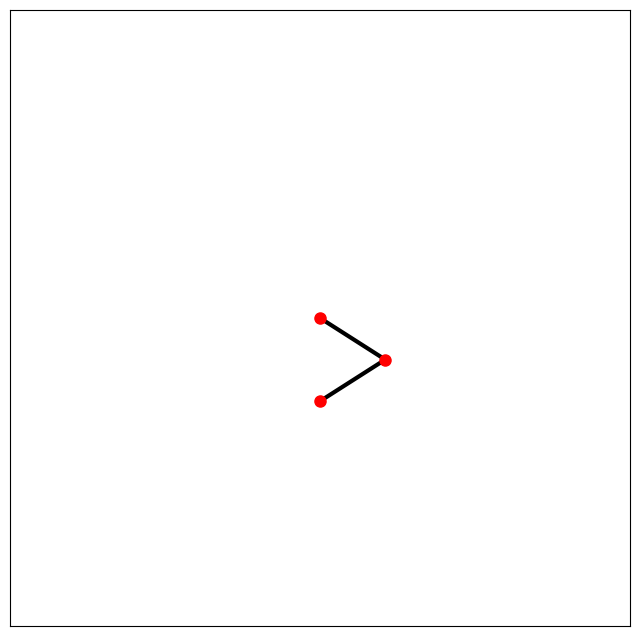

In [3]:
t = np.linspace(0, 40, 1001)
g = 9.81
m1=2
m2=1
L1 = 1
L2 = 1

ans = odeint(dSdt, y0=[1, -3, -1, 5], t=t, args=(g,m1,m2,L1,L2))
x1_hist, y1_hist, x2_hist, y2_hist = get_x1y1x2y2_hist(t, ans.T[0], ans.T[2], L1, L2)
fig, ax = plt.subplots(1,1, figsize=(8,8)) 
ax.set_facecolor('white') 
ax.get_xaxis().set_ticks([])    
ax.get_yaxis().set_ticks([])    
ln1, = plt.plot([], [], 'k-', lw=3)  
markers, = plt.plot([], [], 'ro', markersize=8)  
ax.set_ylim(-4,4)
ax.set_xlim(-4,4)
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
# HTML(ani.to_jshtml())
ani.save('pen.gif',writer='pillow',fps=25)